In [1]:
import os
os.chdir('../../')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pipeline.data import VolumeDataset

[INFO] raw_data contains 22 missing observations


,log_diff_volume,log_return,relative_open,relative_high,relative_low,relative_close
count,107561.000000,107561.000000,107562.000000,107562.000000,107562.000000,107562.000000
mean,0.000014,0.000673,1.000008,1.000697,0.999303,1.000011
std,0.460259,0.151054,0.000685,0.000694,0.000694,0.000671
min,-6.521920,-11.752031,0.977501,1.000000,0.964208,0.982952
25%,-0.271006,-0.042091,0.999744,1.000328,0.999167,0.999762
50%,-0.009943,0.002263,1.000000,1.000518,0.999482,1.000024
75%,0.262094,0.044699,1.000265,1.000833,0.999672,1.000270
max,9.517652,6.182158,1.029992,1.035792,1.000000,1.030030


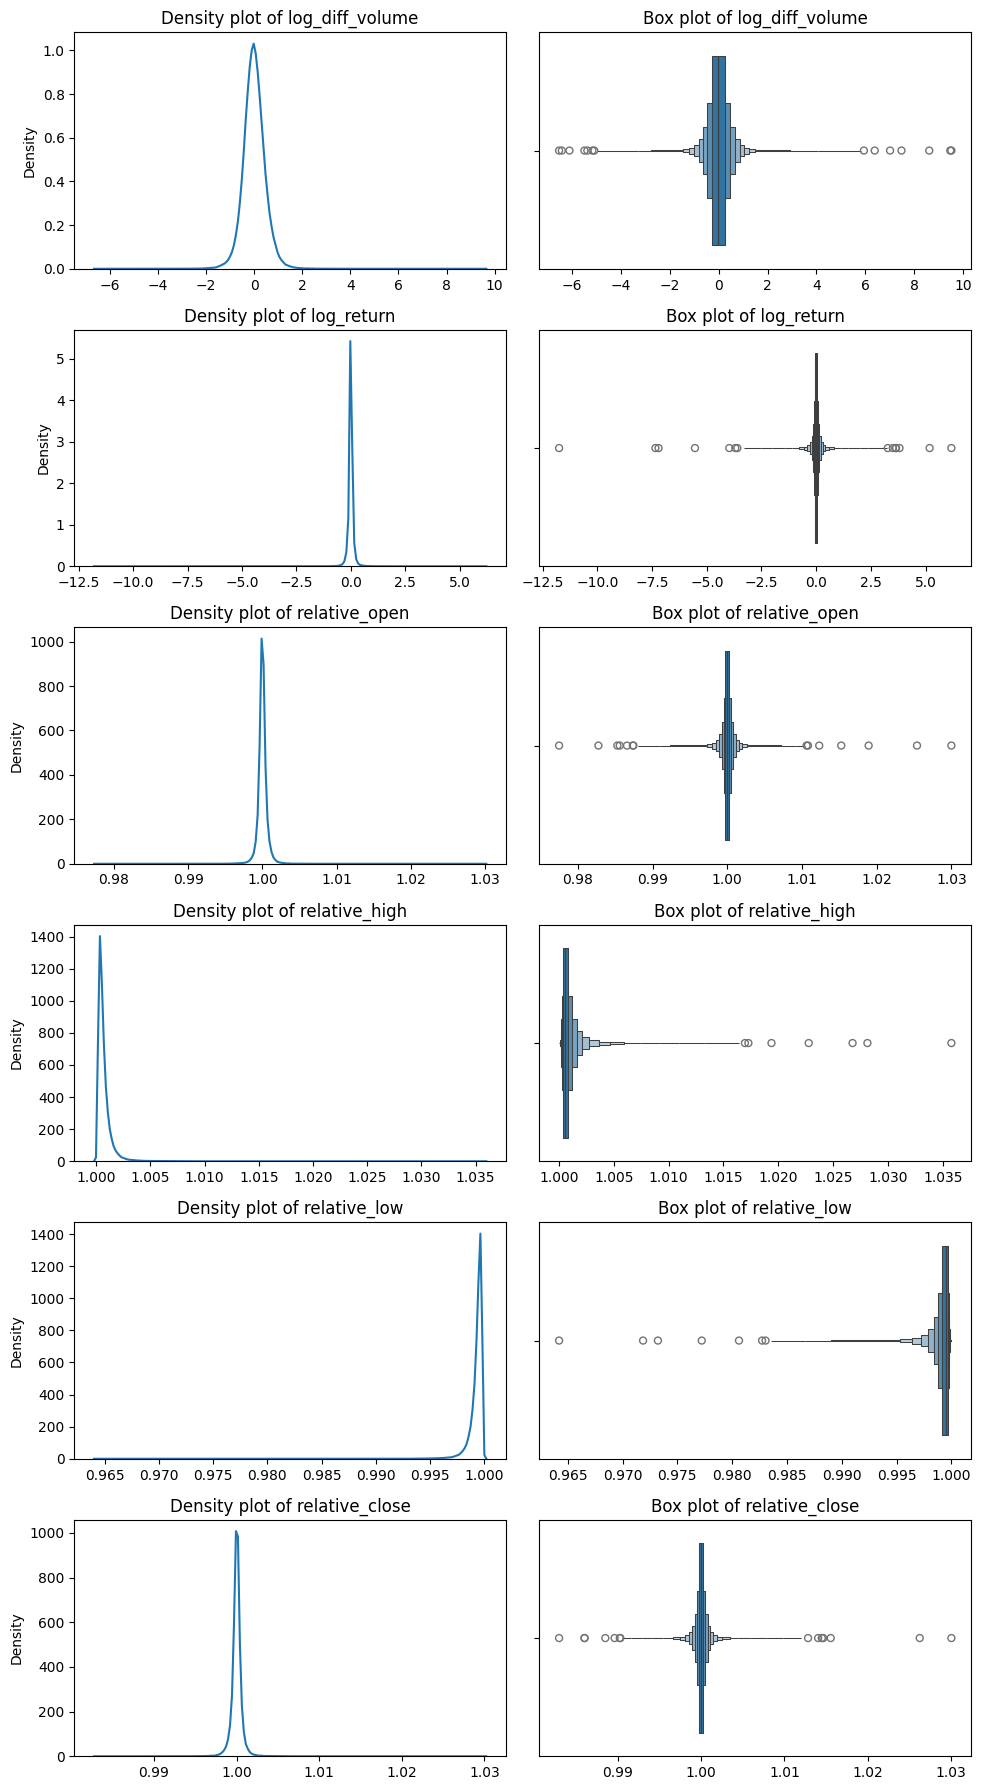

In [2]:
# Load all csv files
raw_data = pd.concat([
    pd.read_csv(f'pipeline/dataset/raw/spy_{month.strftime("%Y_%m")}.csv', parse_dates=['date'], index_col=['date'])
    for month in pd.date_range(start='2020-01-01', end='2025-06-30', freq='ME')
])

# Pad missing entries and forward fill (for simplicity)
market_open = pd.to_datetime('09:30:00').time()
market_close = pd.to_datetime('16:00:00').time()
full_index = pd.date_range(start='2020-01-01', end='2025-06-30', freq='5min')
mask = pd.Series(full_index.date).isin(raw_data.index.date) & (pd.Series(full_index.time) >= market_open) & (pd.Series(full_index.time) < market_close)
raw_data = raw_data.reindex(full_index[mask])
print(f'[INFO] raw_data contains {raw_data.isna().any(axis=1).sum()} missing observations')
raw_data = raw_data.ffill()                                 # Can be more complex imputation methods
raw_data.index = raw_data.index + pd.Timedelta(minutes=5)   # Index on closing datetime

# Perform feature engineering
raw_data['log_diff_volume'] = np.log(raw_data['volume']) - np.log(raw_data['volume'].shift())
raw_data['log_return'] = 100 * (np.log(raw_data['close']) - np.log(raw_data['close'].shift()))
raw_data['mid_price'] = 0.5 * (raw_data['high'] + raw_data['low'])
raw_data['relative_open'] = raw_data['open'] / raw_data['mid_price']
raw_data['relative_high'] = raw_data['high'] / raw_data['mid_price']
raw_data['relative_low'] = raw_data['low'] / raw_data['mid_price']
raw_data['relative_close'] = raw_data['close'] / raw_data['mid_price']
raw_data = raw_data[['log_diff_volume', 'log_return', 'relative_open', 'relative_high', 'relative_low', 'relative_close']]

# Examine each feature
display(raw_data.describe())
plt.figure(figsize=(10, 3 * len(raw_data.columns)))
for i, col in enumerate(raw_data.columns):
    plt.subplot(len(raw_data.columns), 2, 2 * i + 1)
    sns.kdeplot(x=raw_data[col])
    plt.title(f'Density plot of {col}')
    plt.xlabel('')
    plt.subplot(len(raw_data.columns), 2, 2 * i + 2)
    sns.boxenplot(x=raw_data[col])
    plt.title(f'Box plot of {col}')
    plt.xlabel('')
plt.tight_layout()
plt.show()

In [3]:
# Sense check
idx = 0
dataset = VolumeDataset(start_date=pd.to_datetime('2021-01-01'), end_date=pd.to_datetime('2021-12-31'), sequence_length=78, force_reload=True)
display(pd.DataFrame(dataset[idx][0].numpy()))                  # Input features
print(dataset[idx][1])                                          # Target variable
print(dataset.index_to_datetime(dataset.get_index(idx)[0]))     # Input datetime index
print(dataset.index_to_datetime(dataset.get_index(idx)[1]))     # Target datetime index

[INFO] raw_data contains 22 missing observations


,0,1,2,3,4,5
0,-1.503145,0.184385,1.000893,1.001267,0.998733,0.998840
1,-0.724957,-0.146384,1.000788,1.000949,0.999051,0.999351
2,-0.289847,0.031533,1.000401,1.000776,0.999224,1.000749
3,0.040176,0.021359,0.999840,1.000481,0.999519,1.000080
4,0.154566,-0.155100,1.001418,1.001445,0.998555,0.999893
...,...,...,...,...,...,...
73,-0.129685,0.110320,0.999688,1.000828,0.999172,1.000818
74,0.103829,0.011825,1.000018,1.000570,0.999430,1.000136
75,0.352216,0.157189,0.999160,1.001003,0.998997,1.000759
76,0.777673,-0.067734,0.999959,1.000853,0.999147,0.999282


tensor([-1.8574])
DatetimeIndex(['2021-01-04 09:35:00', '2021-01-04 09:40:00',
               '2021-01-04 09:45:00', '2021-01-04 09:50:00',
               '2021-01-04 09:55:00', '2021-01-04 10:00:00',
               '2021-01-04 10:05:00', '2021-01-04 10:10:00',
               '2021-01-04 10:15:00', '2021-01-04 10:20:00',
               '2021-01-04 10:25:00', '2021-01-04 10:30:00',
               '2021-01-04 10:35:00', '2021-01-04 10:40:00',
               '2021-01-04 10:45:00', '2021-01-04 10:50:00',
               '2021-01-04 10:55:00', '2021-01-04 11:00:00',
               '2021-01-04 11:05:00', '2021-01-04 11:10:00',
               '2021-01-04 11:15:00', '2021-01-04 11:20:00',
               '2021-01-04 11:25:00', '2021-01-04 11:30:00',
               '2021-01-04 11:35:00', '2021-01-04 11:40:00',
               '2021-01-04 11:45:00', '2021-01-04 11:50:00',
               '2021-01-04 11:55:00', '2021-01-04 12:00:00',
               '2021-01-04 12:05:00', '2021-01-04 12:10:00',
      